In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"

In [ ]:
class Network(nn.Module):

  def __init__(self, input, width, depth, output):
    super().__init__()

    # activation function
    activation = nn.Tanh

    # input layer
    self.fci = nn.Sequential(*[nn.Linear(input, depth), activation()])

    # hidden layers
    self.fch = nn.Sequential(*[nn.Sequential(*[nn.Linear(depth, depth), activation()]) for i in range(width-1)])

    # output layer
    self.fco = nn.Linear(depth, output)

  # forward propagation
  def forward(self, x, t):
    x = torch.cat((x, t), dim = 1)
    x = self.fci(x)
    x = self.fch(x)
    x = self.fco(x)
    return x

In [ ]:
# exact solution of modelling coursework
def TransientAnalyticSoln(x, t):

    trans = 0
    for k in range(1, 1001):
        trans += ((((-1)**k)/k) * np.exp(-k**2*np.pi**2*t)*np.sin(k*np.pi*x))
    c = x + (2/np.pi)*trans
    return c

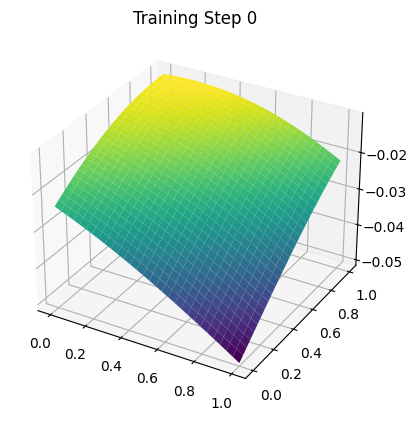

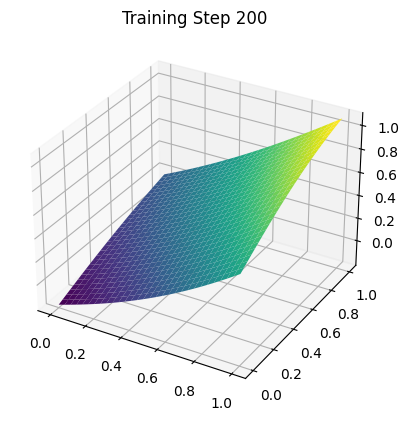

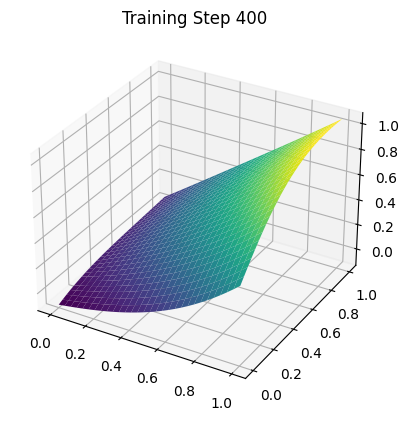

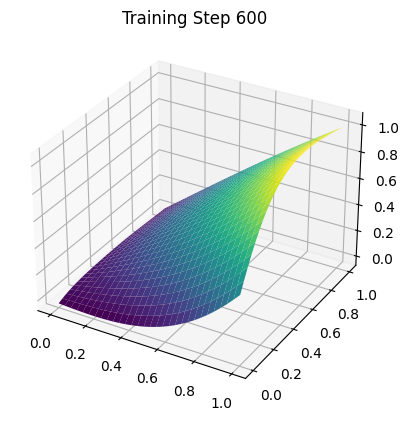

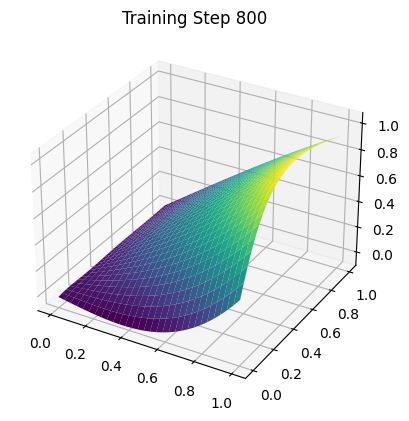

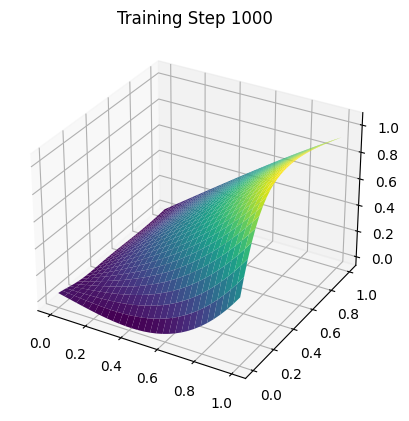

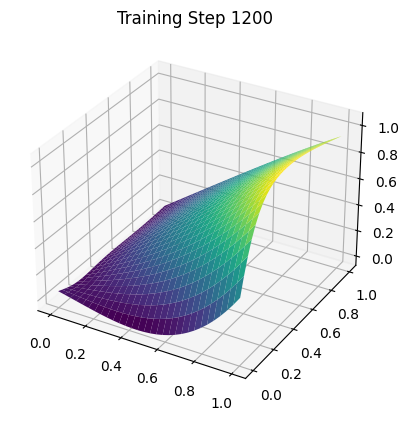

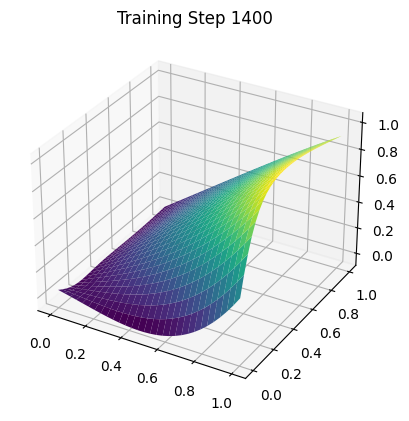

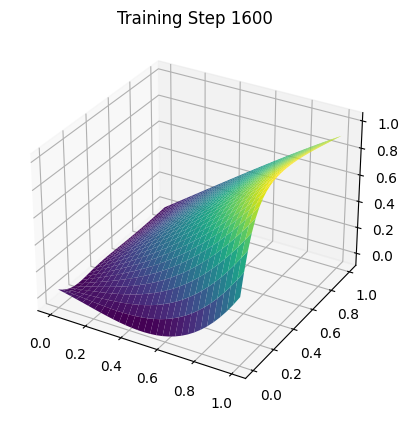

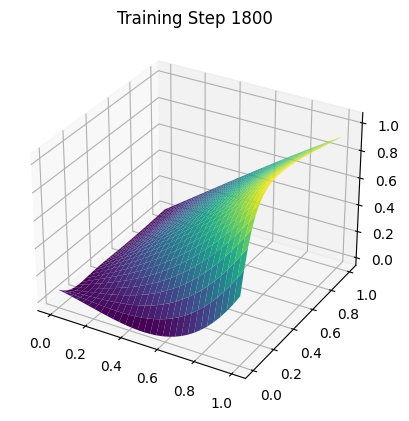

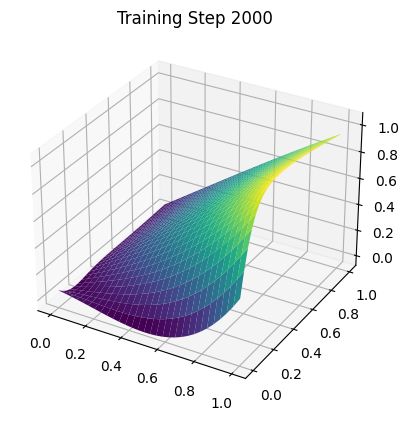

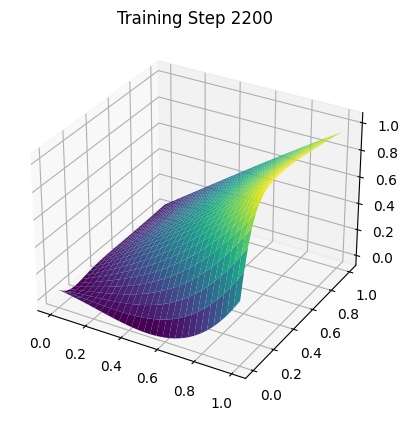

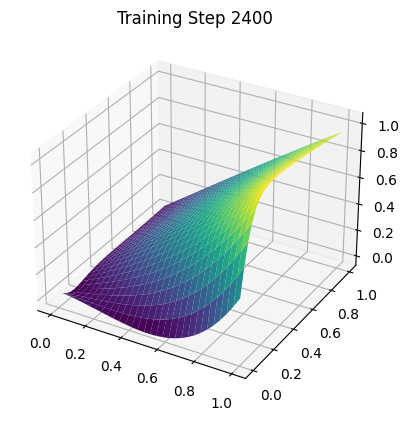

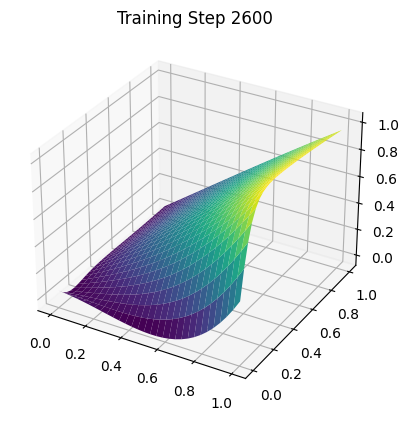

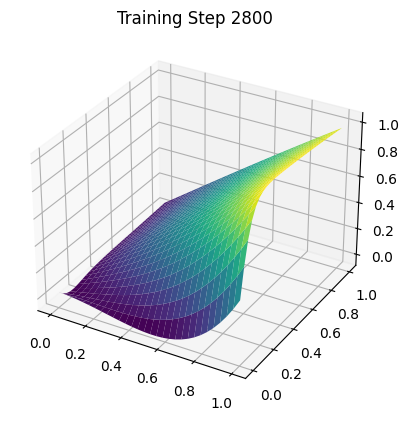

In [ ]:
# nn seed
torch.manual_seed(123)

# define nn to train, two inputs for x and t
pinn = Network(2, 3, 32, 1).to(device)

# x and t boundary points for training x boundaries, x = 0,1, varying t values
x0_boundary = torch.tensor(0.).view(-1, 1).requires_grad_(True).to(device)
x1_boundary = torch.tensor(1.).view(-1, 1).requires_grad_(True).to(device)
t_boundaries = torch.linspace(0, 1, 30).view(-1, 1).requires_grad_(True).to(device)

# 0 time boundary for training
t0_boundary = torch.tensor(0.).view(-1, 1).requires_grad_(True).to(device)
x_boundary = torch.linspace(0, 1, 30).view(-1, 1).requires_grad_(True).to(device)




# equation parameters
D = 1

# training things
epochs = 3000
lr = 1e-3
lambda1 = 1e-2
lambda2 = 1e-2

# optimiser
optimiser = torch.optim.Adam(pinn.parameters(), lr = lr)


for e in range(epochs):

  optimiser.zero_grad()

  # x, t for phsyics loss
  x_physics = torch.rand(30).requires_grad_(True).to(device)
  t_physics = torch.rand(30).requires_grad_(True).to(device)

  # x0 boundary loss
  outputs = []
  for t in t_boundaries:
    t = t.unsqueeze(1)
    c = pinn(x0_boundary, t)
    outputs.append(c)

  outputs_tensor = torch.cat(outputs, dim=1)
  x0_loss = torch.mean(outputs_tensor**2)

  # x1 boundary loss
  outputs = []
  for t in t_boundaries:
    t = t.unsqueeze(1)
    c = pinn(x1_boundary, t)
    outputs.append(c)

  outputs_tensor = torch.cat(outputs, dim=1)
  x1_loss = torch.mean((outputs_tensor-1)**2)

  # t boundary loss
  outputs = []
  for x in x_boundary:
    x = x.unsqueeze(1)
    c = pinn(x, t0_boundary)
    outputs.append(c)

  outputs_tensor = torch.cat(outputs, dim=1)
  t_loss = torch.mean(outputs_tensor**2)


  # physics loss function

  dcdxs = []
  d2cdx2s = []
  dcdts = []
  cs = []
  for x,t in zip(x_physics,t_physics):
    x = x.unsqueeze(0)
    t = t.unsqueeze(0)
    x = x.unsqueeze(1)
    t = t.unsqueeze(1)

    c = pinn(x, t)
    cs.append(c)
    dcdx = torch.autograd.grad(c, x, torch.ones_like(x), create_graph = True)[0]
    d2cdx2 = torch.autograd.grad(dcdx, x, torch.ones_like(x), create_graph = True)[0]

    dcdt = torch.autograd.grad(c, t, torch.ones_like(t), create_graph = True)[0]

    dcdxs.append(dcdx)
    d2cdx2s.append(d2cdx2)

    dcdts.append(dcdt)

  d2cdx2_tensor = torch.cat(d2cdx2s, dim = 1)
  dcdt_tensor = torch.cat(dcdts, dim = 1)
  loss_phys = torch.mean((D*d2cdx2_tensor - dcdt_tensor)**2)

  loss = lambda1 * (x0_loss + x1_loss + t_loss) + lambda2 * loss_phys

  loss.backward()
  optimiser.step()

  if e % 200 == 0:

    X = torch.linspace(0, 1, 30)
    T = torch.linspace(0, 1, 30)
    cs = np.zeros((30, 30))

    for i, x in enumerate(X):
        x = x.unsqueeze(0)
        x = x.unsqueeze(1)
        for j, t in enumerate(T):
            t = t.unsqueeze(0)
            t = t.unsqueeze(1)

            c = pinn(x, t)
            cs[i, j] = c


    X, T = np.meshgrid(X.numpy(), T.numpy())

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface
    ax.plot_surface(T, X, cs, cmap='viridis')

    plt.title(f"Training Step {e}")
    plt.show()

Parameter containing:
tensor([0.], requires_grad=True)


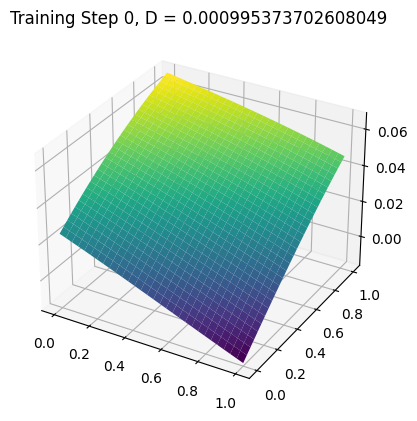

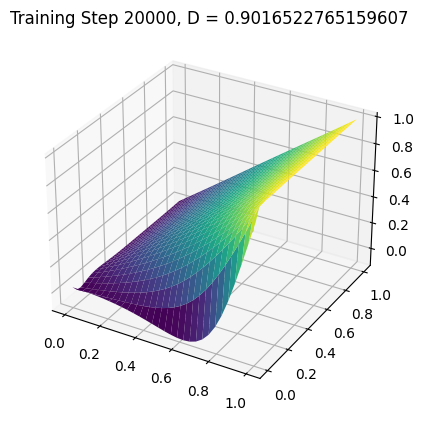

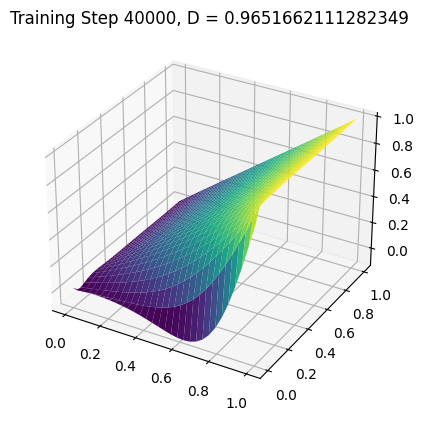

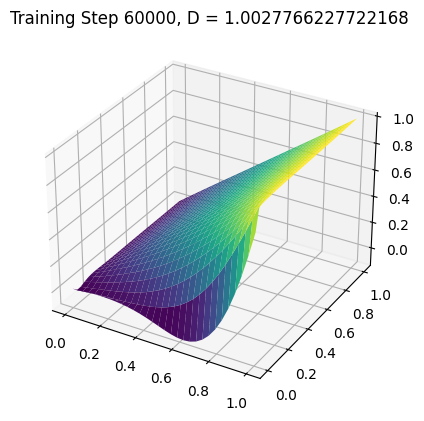

In [ ]:
# inverse problem
inverse_PINN = Network(2, 3, 32, 1)

cs_analytical = []
Ds = []

# x, t for phsyics loss
x_points = torch.rand(100).requires_grad_(True).to(device)
t_points = torch.rand(100).requires_grad_(True).to(device)

for x,t in zip(x_points,t_points):

  x = x.detach().numpy()
  t = t.detach().numpy()
  c = TransientAnalyticSoln(x, t)
  cs_analytical.append(c)

# training things
epochs = 100000
lr = 1e-3
lambda1 = 1e4
lambda2 = 1e-1

# optimiser
D = torch.nn.Parameter(torch.zeros(1, requires_grad = True))
print(D)
optimiser = torch.optim.Adam(list(inverse_PINN.parameters()) + [D], lr = lr)

# training loop
for e in range(epochs):

  optimiser.zero_grad()

  # x, t for phsyics loss
  x_physics = torch.rand(30).requires_grad_(True).to(device)
  t_physics = torch.rand(30).requires_grad_(True).to(device)


  # rms vs analyitcal solution loss

  losses = []
  for i in range(len(x_points)):

    x = x_points[i].view(-1, 1)
    t = t_points[i].view(-1, 1)

    c = cs_analytical[i]
    out = inverse_PINN(x, t)

    loss = (out - torch.tensor(c))**2
    losses.append(loss)

  loss1 = torch.mean(torch.stack(losses))


  # physics loss
  c_xs = []
  c_xxs = []
  c_ts = []

  for i in range(len(x_physics)):

    x = x_physics[i].view(-1, 1)
    t = t_physics[i].view(-1, 1)

    c = inverse_PINN(x, t)

    c_x = torch.autograd.grad(c, x, torch.ones_like(x), create_graph = True)[0]
    c_xx = torch.autograd.grad(c_x, x, torch.ones_like(x), create_graph = True)[0]

    c_t = torch.autograd.grad(c, t, torch.ones_like(t), create_graph = True)[0]

    c_xs.append(c_x)
    c_xxs.append(c_xx)

    c_ts.append(c_t)

  c_xx_tensor = torch.cat(c_xxs, dim = 1)
  c_t_tensor = torch.cat(c_ts, dim = 1)
  loss_phys = torch.mean((D*c_xx_tensor - c_t_tensor)**2)

  loss = lambda1*loss1 + lambda2*loss_phys
  Ds.append(D.item())
  loss.backward()
  optimiser.step()

  if e % 20000 == 0:

    X = torch.linspace(0, 1, 30)
    T = torch.linspace(0, 1, 30)
    cs = np.zeros((30, 30))

    for i, x in enumerate(X):
        x = x.unsqueeze(0)
        x = x.unsqueeze(1)
        for j, t in enumerate(T):
            t = t.unsqueeze(0)
            t = t.unsqueeze(1)

            c = torch.flatten(inverse_PINN(x, t))
            cs[i, j] = c[0]


    X, T = np.meshgrid(X.numpy(), T.numpy())
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the surface
    ax.plot_surface(T, X, cs, cmap='viridis')

    plt.title(f"Training Step {e}, D = {D.item()}")
    plt.show()



In [ ]:
# ds_flattened = [tensor.flatten().detach().numpy() for tensor in Ds]

# plot Ds
plt.plot(Ds)
plt.show()

NameError: name 'plt' is not defined